In [1]:
import pandas as pd
df = pd.read_csv('/content/dataset_for_SI_clean (1).csv')
df.head()

,SI,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,log_IC50,log_CC50
0,7.00,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,...,0,0,0,0,0,0,3,0,0.572014,1.856738
1,0.72,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,...,0,0,0,0,0,0,3,0,5.415250,5.088474
2,1.30,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,0.062897,-0.257239,0.600000,...,0,0,0,0,0,0,0,0,4.683348,4.943576
3,2.00,5.758408,0.278083,0.278083,0.711012,28.600000,332.491,0.062897,-0.398729,0.960000,...,0,0,0,0,0,0,0,0,2.774955,3.436430
4,0.77,2.584472,0.429649,0.429649,0.328539,36.564103,528.869,0.132160,-0.293073,0.564103,...,0,0,0,0,0,0,0,0,2.991130,2.744658


In [2]:
!pip install catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

# Удаление потенциальной утечки
leaks = [c for c in df.columns if 'IC50' in c.upper() or 'CC50' in c.upper()]
X = df.drop(columns=leaks + ['SI'], errors='ignore')

# Целевая переменная: SI > медианы
y = (df['SI'] > df['SI'].median()).astype(int)

# Тренировочный и тестовый сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("LogisticRegression:")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]):.3f}\n")

#  Random Forest
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest:")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.3f}")

LogisticRegression:
F1 Score: 0.551
ROC AUC: 0.535

RandomForest:
F1 Score: 0.565
ROC AUC: 0.575


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:29:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LogReg:
  F1 Score: 0.551
  ROC AUC : 0.535
RandomForest:
  F1 Score: 0.545
  ROC AUC : 0.578
XGBoost:
  F1 Score: 0.481
  ROC AUC : 0.527


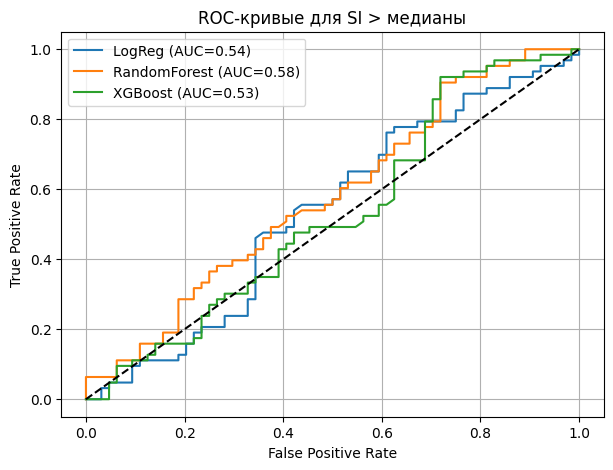

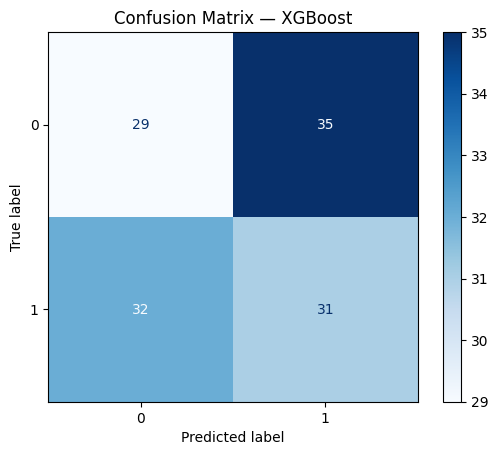

In [8]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
leaks = [c for c in df.columns if 'IC50' in c.upper() or 'CC50' in c.upper()]
X = df.drop(columns=leaks + ['SI'], errors='ignore')
y = (df['SI'] > df['SI'].median()).astype(int)

# Сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
lr_pred = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
rf_pred = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=80, max_depth=4, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict(X_test)

# Вывод метрик
for name, y_p, y_prob in zip(
    ['LogReg', 'RandomForest', 'XGBoost'],
    [lr_pred, rf_pred, xgb_pred],
    [lr_probs, rf_probs, xgb_probs]
):
    print(f"{name}:")
    print(f"  F1 Score: {f1_score(y_test, y_p):.3f}")
    print(f"  ROC AUC : {roc_auc_score(y_test, y_prob):.3f}")

# ROC-кривые
plt.figure(figsize=(7,5))
for label, probs in zip(['LogReg', 'RandomForest', 'XGBoost'], [lr_probs, rf_probs, xgb_probs]):
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{label} (AUC={auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для SI > медианы')
plt.legend()
plt.grid(True)
plt.show()

# Матрица ошибок для лучшей модели (например, XGBoost)
cm = confusion_matrix(y_test, xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix — XGBoost")
plt.show()

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Удаление утечек
leaks = [c for c in df.columns if 'IC50' in c.upper() or 'CC50' in c.upper()]
X = df.drop(columns=leaks + ['SI'], errors='ignore')
y = (df['SI'] > df['SI'].median()).astype(int)

# Сплит и масштабирование
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Модели
models = {
    'LogReg': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

# Обучение и оценка
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    print(f"{name}: F1 = {f1:.3f}, ROC AUC = {roc:.3f}")


LogReg: F1 = 0.614, ROC AUC = 0.568
RandomForest: F1 = 0.574, ROC AUC = 0.569
MLP: F1 = 0.523, ROC AUC = 0.520


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


LogReg: F1 = 0.614, ROC AUC = 0.568
RandomForest: F1 = 0.574, ROC AUC = 0.569
MLP: F1 = 0.547, ROC AUC = 0.479


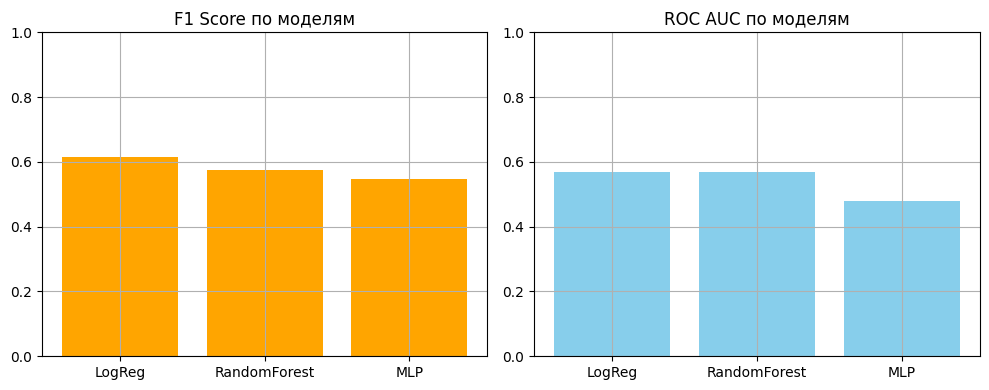

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Загрузка и подготовка
df = pd.read_csv('/content/dataset_for_SI_clean (1).csv')
leaks = [c for c in df.columns if 'IC50' in c.upper() or 'CC50' in c.upper()]
X = df.drop(columns=leaks + ['SI'], errors='ignore')
y = (df['SI'] > df['SI'].median()).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Модели
models = {
    'LogReg': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, early_stopping=True, random_state=42)
}

results = []

# Обучение и оценка
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    results.append({'Model': name, 'F1 Score': f1, 'ROC AUC': roc})
    print(f"{name}: F1 = {f1:.3f}, ROC AUC = {roc:.3f}")

# Таблица
df_results = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

# Визуализация
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.bar(df_results['Model'], df_results['F1 Score'], color='orange')
plt.title('F1 Score по моделям')
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(df_results['Model'], df_results['ROC AUC'], color='skyblue')
plt.title('ROC AUC по моделям')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
!pip install imbalanced-learn --quiet


LogReg: F1 = 0.614, ROC AUC = 0.568
RandomForest: F1 = 0.574, ROC AUC = 0.569
MLP: F1 = 0.547, ROC AUC = 0.479


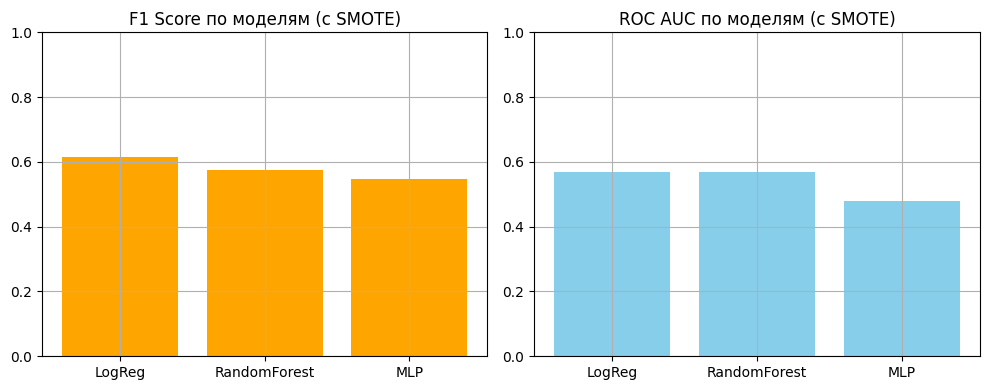

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

df = pd.read_csv('/content/dataset_for_SI_clean (1).csv')

# Удаление потенциальных утечек
leaks = [c for c in df.columns if 'IC50' in c.upper() or 'CC50' in c.upper()]
X = df.drop(columns=leaks + ['SI'], errors='ignore')
y = (df['SI'] > df['SI'].median()).astype(int)

# Сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# SMOTE балансировка
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# Модели
models = {
    'LogReg': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, early_stopping=True, random_state=42)
}

results = []

# Обучение и оценка
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca)[:, 1]
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    results.append({'Model': name, 'F1 Score': f1, 'ROC AUC': roc})
    print(f"{name}: F1 = {f1:.3f}, ROC AUC = {roc:.3f}")

# Таблица
df_results = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

# Визуализация
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.bar(df_results['Model'], df_results['F1 Score'], color='orange')
plt.title('F1 Score по моделям (с SMOTE)')
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(df_results['Model'], df_results['ROC AUC'], color='skyblue')
plt.title('ROC AUC по моделям (с SMOTE)')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()